In [149]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from itertools import product
from sfp_nsdsyn import utils, sfm, tuning
from pysurfer.mgz_helper import get_vertices_in_labels, read_label, get_existing_labels_only

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
nsd_dir ='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset'
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
fs_subj_dir='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsddata/freesurfer'
overlay_dir='/Volumes/server/Projects/sfp_nsd/derivatives/sfp_maps/mgzs/nsdsyn'
fig_dir='/Volumes/server/Projects/sfp_nsd/derivatives/figures/brain_maps/nsdsyn'
sn_list = [f'subj{sn:02d}' for sn in np.arange(1,9)]

In [4]:
# Additional matplotlib preferences:
font_data = {'family':'sans-serif',
             'sans-serif':['HelveticaNeue', 'Helvetica', 'Arial'],
             'size': 10}
mpl.rc('font',**font_data)
# we want relatively high-res images, especially when saving to disk.
#mpl.rcParams['figure.dpi'] = 72*2
#mpl.rcParams['savefig.dpi'] = 72*4

In [77]:
labels = ['V1v', 'V1d', 'V2v','V2d', 'V3v','V3d', 'hV4', 'pFFA','aFFA','PPA']
sn = 'subj01'
hemi = 'lh'
label_path = [os.path.join(fs_subj_dir, sn, 'label', f'{hemi}.V1v.label')]

In [89]:
lh_rois, lh_voxels = {}, {}
rh_rois, rh_voxels = {}, {}
my_val = 'r2'
ref_frame = 'absolute'

for sn in sn_list:
    label_dir = os.path.join(fs_subj_dir, sn, 'label')
    lh_labels, lh_label_paths = get_existing_labels_only(labels, label_dir, 'lh', return_paths=True)
    rh_labels, rh_label_paths = get_existing_labels_only(labels, label_dir, 'rh', return_paths=True)

    mgz_path = os.path.join(overlay_dir, f'lh.sub-{sn}_value-{my_val}_frame-{ref_frame}.mgz')
    lh_rois[sn], lh_voxels[sn] = get_vertices_in_labels(mgz_path, lh_label_paths, lh_labels, load_mgz=True, return_label=True)

    mgz_path = os.path.join(overlay_dir, f'rh.sub-{sn}_value-{my_val}_frame-{ref_frame}.mgz')
    rh_rois[sn], rh_voxels[sn] = get_vertices_in_labels(mgz_path, rh_label_paths, rh_labels, load_mgz=True, return_label=True)

In [122]:
def breakdown_dfs(value_dict, voxel_dict, sn_list, hemi='lh'):
    hemi_df = pd.DataFrame({})
    for sn in sn_list:
        for roi in value_dict[sn].keys():
            tmp = pd.DataFrame({})
            tmp['value'] = value_dict[sn][roi]
            tmp['voxel'] = voxel_dict[sn][roi]
            tmp['ROI'] = roi
            tmp['hemi'] = hemi
            tmp['sub'] = sn
            hemi_df = pd.concat((hemi_df, tmp))
    return hemi_df

In [123]:
lh_df = breakdown_dfs(lh_rois, lh_voxels, sn_list)
rh_df = breakdown_dfs(rh_rois, rh_voxels, sn_list, hemi='rh')
all_df = pd.concat((lh_df, rh_df))

In [11]:
# Define a colormap from Matplotlib
cmap = plt.cm.get_cmap('Blues_r')

# Define the number of colors based on the number of ROIs
ret_colors = [cmap(i / 10) for i in range(10)]
colors = []
colors += [ret_colors[0], ret_colors[0], ret_colors[2], ret_colors[2], ret_colors[4], ret_colors[4], ret_colors[6]]
# Define a colormap from Matplotlib
colors += ['magenta', 'magenta']
colors += ['gray']
palette = dict(zip(labels, colors))

In [26]:
np.log10(all_df["Goodness of fit (R2)"].min())

/Users/jh7685/opt/miniconda3/envs/sfp/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


nan

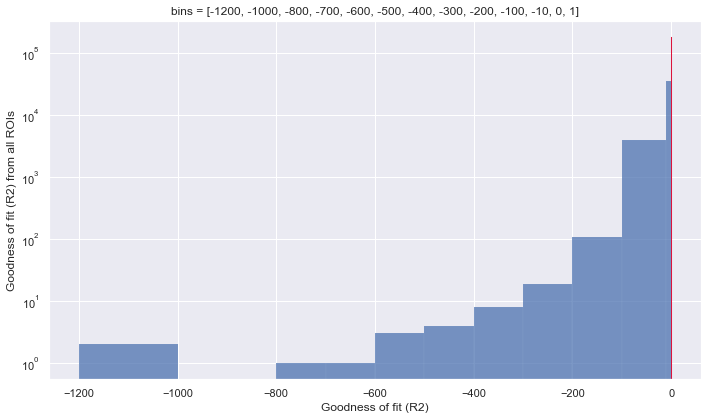

In [73]:
# Set the size of the figure
sns.set_theme()
save_path=os.path.join(fig_dir, 'histogram_r2_all_rois.png')
plt.figure(figsize=(10, 6))  # Adjust the size as needed
custom_palette = ['grey']*2 + ['red']*9
bin_edges = [-1200, -1000, -800, -700, -600, -500, -400, -300, -200, -100, -10, 0, 1]
ax = sns.histplot(x='Goodness of fit (R2)', data=all_df, bins=bin_edges, palette=custom_palette)
heights = [p.get_height() for p in ax.patches]
highest = sorted(heights)[-1]
for p in ax.patches:
    if  p.get_height() == highest:
        p.set_color('crimson')
ax.set_ylabel('Goodness of fit (R2) from all ROIs')
ax.set_yscale('log')
ax.set_title('bins = [-1200, -1000, -800, -700, -600, -500, -400, -300, -200, -100, -10, 0, 1]')
utils.save_fig(save_path)
plt.tight_layout()

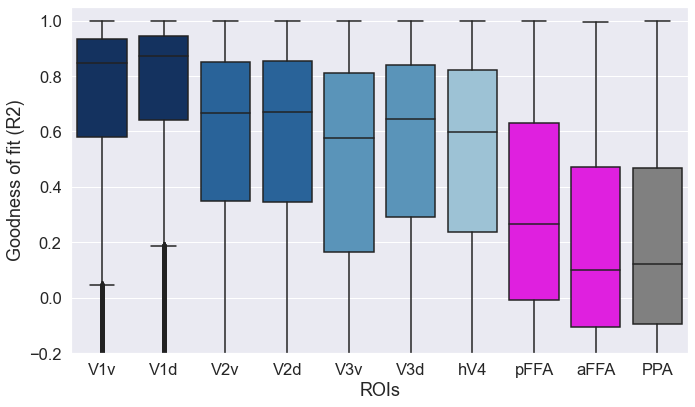

In [83]:
# Set the size of the figure
sns.set_theme('notebook', font_scale=1.5)
save_path=os.path.join(fig_dir, 'boxplot_r2_all_rois_within_0-1.png')
plt.figure(figsize=(10, 6))  # Adjust the size as needed
ax = sns.boxplot(x='ROI', y='Goodness of fit (R2)', data=all_df, palette=palette, order=labels)
ax.set_ylabel('Goodness of fit (R2)')
ax.set_ylim(-0.2, 1.05)
ax.set_xlabel('ROIs')
plt.tight_layout()
utils.save_fig(save_path)

# Tuning comparison

## Choose voxels based on what R2 value they have

In [195]:
# Define the bins
bins = [-1200,-100,-1,0,0.5,0.7,0.9,1]

# Define the category labels
labels = ['severely negative', 'negative','-1 to 0', '0-0.5', '0.5-0.7', '0.7-0.9', '<0.9']

# Applying the bins to the data
all_df['category'] = pd.cut(all_df['value'], bins=bins, labels=labels, right=False)

In [197]:
sampled_df = all_df.query('sub == "subj01" & hemi == @hemi')
sampled_df = sampled_df.groupby('category').apply(lambda x: x.sample(n=3, replace=False)).reset_index(drop=True)

In [198]:
voxel_list = sampled_df.sort_values('value').voxel.unique().tolist()

## Load in betas dataframe and merge it with the sampled df

In [169]:
subj='subj01'
hemi='lh'
betas = os.path.join(nsd_dir, 'nsddata_betas', 'ppdata', f'{subj}', 'nativesurface', 'nsdsyntheticbetas_fithrf_GLMdenoise_RR', f'{hemi}.betas_nsdsynthetic.hdf5')
design_mat=os.path.join(nsd_dir, 'nsddata', 'experiments', 'nsdsynthetic', 'nsdsynthetic_expdesign.mat')
task_keys=['fixation_task','memory_task']
stim_info=os.path.join(nsd_dir, 'nsdsyn_stim_description.csv')
task_average=True
eccentricity_path= os.path.join(nsd_dir, 'nsddata', 'freesurfer', f'{subj}', 'label',  f'{hemi}.prfeccentricity.mgz')

In [170]:
def load_in_sample_voxels(voxel_list, betas, design_mat, stim_info, task_keys, task_average, eccentricity_path, ref_frame):

    betas_df = sfm.get_whole_brain_betas(betas_path=betas, design_mat_path=design_mat,
                          stim_info_path=stim_info,
                          task_keys=task_keys, task_average=task_average, eccentricity_path=eccentricity_path,
                          x_axis='voxel', y_axis='stim_idx', long_format=True, reference_frame=ref_frame)
    betas_df = betas_df.query('voxel in @voxel_list')
    betas_df = betas_df.query('~names.str.contains("intermediate").values')
    betas_df = betas_df.groupby(['freq_lvl','voxel']).mean().reset_index()
    return betas_df


In [199]:
sampled_betas = load_in_sample_voxels(voxel_list, betas, design_mat, stim_info, task_keys, task_average, eccentricity_path, ref_frame)

In [200]:
sampled_p_opt = pd.read_hdf(os.path.join(output_dir, "sfp_maps", "voxel-tuning", "nsdsyn", f"hemi-{hemi}_sub-{subj}_frame-{ref_frame}.hdf"))
sampled_p_opt = sampled_p_opt.query('voxel in @voxel_list')

In [201]:
sampled_betas = sampled_betas.merge(sampled_df, on='voxel')

In [ ]:
fig, axes = plt.subplots(7,3, sharex=True, sharey=True, figsize=(9,16))
# Flatten the axes array for easy iteration
flat_axes = axes.flatten()
sns.set_theme()
for i, v in enumerate(voxel_list):
    v_tmp = sampled_betas.query('voxel == @v')
    p_opt_tmp = sampled_p_opt.query('voxel == @v')
    r2_val = np.round(sampled_betas.query('voxel == @v')['value'].unique().item(), 2)
    roi = sampled_betas.query('voxel == @v')['ROI'].unique().item()
    tuning.plot_logGaussian_fit(v_tmp, 'local_sf', 'betas', p_opt_tmp, flat_axes[i], ax_title=f'voxel {v}\nr2={r2_val} ({roi})')
utils.save_fig(os.path.join(fig_dir, 'subj01-lh-tuning-based-on-r2.png'))

In [152]:
len(voxel_list)

24